## Value Function Pre-training

#### In this notebook we:
    - Train a value function (VF) with supervised learning
    - Use KSP-FF to select actions for the VF pre-training
    - Use the pre-rained VF in a PPO agent for the same task
    - Compare performance against our baseline agent

Using a pre-trained value function is an interesting idea because it might improve the sample efficiency of our PPO agent, thus speeding up training and achieving a better final performance.

### Define training function:

We define a custom version of PPO to train the VF with heuristic action selection.
The main changes compared to PPO are:
-   Action selection with heuristic
-   Value loss only for loss calculation
-   Supervised learning to minimise MSE loss on value prediction

In [1]:
import jax
import time
import optax
import jax.numpy as jnp
from absl import flags
from flax.training.train_state import TrainState
from gymnax.environments import environment
from tensorflow_probability.substrates.jax.distributions.student_t import entropy

from xlron.environments.env_funcs import process_path_action
from xlron.environments.gn_model.isrs_gn_model import to_dbm
from xlron.environments.dataclasses import EnvState, EnvParams, VONETransition, RSATransition
from xlron.train.train_utils import *


def get_vf_pretrain_fn(
    env: environment.Environment,
    env_params: EnvParams,
    train_state: TrainState,
    config: flags.FlagValues,
) -> Callable:

    # TRAIN LOOP
    def _update_step(runner_state, unused):
        # COLLECT TRAJECTORIES

        def _env_step(runner_state, unused):
            train_state, env_state, last_obs, rng_step, rng_epoch = runner_state

            rng_step, action_key, step_key = jax.random.split(rng_step, 3)
            
            # SELECT ACTION
            action_key = jax.random.split(action_key, config.NUM_ENVS)
            select_action_fn = lambda x: select_action_eval(x, env, env_params, train_state, config)
            select_action_fn = jax.vmap(select_action_fn)
            select_action_state = (action_key, env_state, last_obs)
            env_state, action, _, _ = select_action_fn(select_action_state)
            
            # Get value prediction (we're still training this)
            axes = (None, 0, None) if config.USE_GNN else (None, 0)
            _, value = jax.vmap(train_state.apply_fn, in_axes=axes)(
                train_state.params, *((env_state.env_state, env_params) if config.USE_GNN else tuple([last_obs]))
            )

            # STEP ENV
            step_key = jax.random.split(step_key, config.NUM_ENVS)
            step_fn = lambda x, y, z: env.step(x, y, z, env_params)
            step_fn = jax.vmap(step_fn)
            obsv, env_state, reward, done, info = step_fn(step_key, env_state, action)

            obsv = (env_state.env_state, env_params) if config.USE_GNN else tuple([obsv])
            log_prob = jnp.zeros(config.NUM_ENVS)
            transition = RSATransition(
                done, action, value, reward, log_prob, last_obs, info, env_state.env_state.link_slot_mask
            )
            runner_state = (train_state, env_state, obsv, rng_step, rng_epoch)
                
            return runner_state, transition

        runner_state, traj_batch = jax.lax.scan(
            _env_step, runner_state, None, config.ROLLOUT_LENGTH
        )
        
        # CALCULATE RETURNS AND TD TARGETS
        train_state, env_state, last_obs, rng_step, rng_epoch = runner_state
        last_obs = (env_state.env_state, env_params) if config.USE_GNN else last_obs
        axes = (None, 0, None) if config.USE_GNN else (None, 0)
        _, last_val = jax.vmap(train_state.apply_fn, in_axes=axes)(train_state.params, *last_obs)

        # Calculate GAE as before - this gives us targets for value function
        def _calculate_gae(traj_batch, last_val):
            def _get_advantages(gae_and_next_value, transition):
                gae, next_value = gae_and_next_value
                done, value, reward = (
                    transition.done,
                    transition.value,
                    transition.reward,
                )
                delta = reward + config.GAMMA * next_value * (1 - done) - value
                gae = (
                    delta
                    + config.GAMMA * config.GAE_LAMBDA * (1 - done) * gae
                )
                return (gae, value), gae

            _, advantages = jax.lax.scan(
                _get_advantages,
                (jnp.zeros_like(last_val), last_val),
                traj_batch,
                reverse=True,
                unroll=True,
            )
            return advantages, advantages + traj_batch.value

        advantages, targets = _calculate_gae(traj_batch, last_val)

        # UPDATE VALUE FUNCTION ONLY
        def _update_epoch(update_state, unused):

            def _update_minbatch(train_state, batch_info):
                traj_batch, advantages, targets = batch_info

                def _loss_fn(params, traj_batch, targets):
                    # RERUN NETWORK FOR VALUE ONLY
                    axes = (None, 0, None) if config.USE_GNN else (None, 0)
                    _, value = jax.vmap(train_state.apply_fn, in_axes=axes)(params, *traj_batch.obs)

                    # CALCULATE VALUE LOSS
                    value_losses = jnp.square(value - targets)
                    value_loss = 0.5 * value_losses.mean()
                    total_loss = value_loss

                    return total_loss, (value_loss, )

                grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                total_loss, grads = grad_fn(
                    train_state.params, traj_batch, targets
                )
                train_state = train_state.apply_gradients(grads=grads)
                return train_state, total_loss

            train_state, traj_batch, advantages, targets, rng_step, rng_epoch = update_state
            rng_epoch, perm_key = jax.random.split(rng_epoch, 2)
            batch_size = config.MINIBATCH_SIZE * config.NUM_MINIBATCHES
            assert (
                batch_size == config.ROLLOUT_LENGTH * config.NUM_ENVS
            ), "batch size must be equal to number of steps * number of envs"
            permutation = jax.random.permutation(perm_key, batch_size)
            batch = (traj_batch, advantages, targets)
            batch = jax.tree.map(
                lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
            )
            shuffled_batch = jax.tree.map(
                lambda x: jnp.take(x, permutation, axis=0), batch
            )
            minibatches = jax.tree.map(
                lambda x: jnp.reshape(
                    x, [config.NUM_MINIBATCHES, -1] + list(x.shape[1:])
                ),
                shuffled_batch,
            )
            train_state, total_loss = jax.lax.scan(
                _update_minbatch, train_state, minibatches
            )
            runner_state = (train_state, traj_batch, advantages, targets, rng_step, rng_epoch)
            return runner_state, total_loss

        update_state = (train_state, traj_batch, advantages, targets, rng_step, rng_epoch)
        update_state, loss_info = jax.lax.scan(
            _update_epoch, update_state, None, config.UPDATE_EPOCHS
        )
        train_state = update_state[0]
        metric = traj_batch.info
        rng_step = update_state[4]
        rng_epoch = update_state[5]
        runner_state = (train_state, env_state, last_obs, rng_step, rng_epoch)
        loss_info = {
            "loss/total_loss": loss_info[0].reshape(-1),
            "loss/value_loss": loss_info[1][0].reshape(-1),
        }
        return runner_state, (metric, loss_info)

    def learner_fn(update_state):
        train_state, (metric_info, loss_info) = jax.lax.scan(
            _update_step, update_state, None, config.NUM_UPDATES
        )
        return {"runner_state": train_state, "metrics": metric_info, "loss_info": loss_info}

    return learner_fn

### Define environment

In [2]:
import sys
from xlron.environments.make_env import *
from xlron import parameter_flags

# We load the default flags
FLAGS = flags.FLAGS

total_timesteps = 5000

# Then define our experiment...
env_config = {
    "env_type": "rsa_multiband",
    "k": 5,
    "link_resources": 98,
    "incremental_loading" : True,
    "end_first_blocking": True,
    "topology_name": "nsfnet_deeprmsa_undirected",
    "values_bw": [400],
    "slot_size": 100,
    "interband_gap_start": 4800,
    "interband_gap_width": 200,
    "max_requests": total_timesteps,
    "modulations_csv_filepath": "",
}
# The agent config needs to stay the same for pre-training and re-training
# TODO - change these to match the hyperparameters from your best sweep run
agent_config = {
    "USE_GNN": True,
    "message_passing_steps": 3,
    "gnn_latent": 128,
    "gnn_mlp_layers": 3,
    "ACTION_MASKING": True,
    "output_globals_size_critic": 1,
}
# ... and training details
train_config = {
    "SEED": 0,
    "NUM_LEARNERS": 1,
    "TOTAL_TIMESTEPS": total_timesteps,
    "NUM_ENVS": 10,
    "ROLLOUT_LENGTH": 100,
    "UPDATE_EPOCHS": 5,
    "LR": 5e-5,
    "GAMMA": 1.0, # For pre-training the VF, we don't use a discount factor
    "GAE_LAMBDA": 1.0, # For pre-training the VF, we don't use GAE
    "LR_SCHEDULE": "linear",
    "LAYER_NORM": True,
}

# We convert config to a Box container to make items accessible through both dict and dot notation
config = process_config(FLAGS, **env_config, **agent_config, **train_config)
config

Box({'logtostderr': False, 'alsologtostderr': False, 'log_dir': '', 'v': -1, 'verbosity': -1, 'logger_levels': {}, 'stderrthreshold': 'fatal', 'showprefixforinfo': True, 'chex_n_cpu_devices': 1, 'chex_assert_multiple_cpu_devices': False, 'run_with_pdb': False, 'pdb_post_mortem': False, 'pdb': False, 'run_with_profiling': False, 'profile_file': None, 'use_cprofile_for_profiling': True, 'only_check_args': False, 'test_srcdir': '', 'test_tmpdir': '/var/folders/5j/8r45ty_x4qj7wn99038f8m1c0000gn/T/absl_testing', 'test_random_seed': 301, 'test_randomize_ordering_seed': '', 'xml_output_file': '', 'chex_skip_pmap_variant_if_single_device': True, 'op_conversion_fallback_to_while_loop': True, 'delta_threshold': 0.5, 'tt_check_filter': False, 'tt_single_core_summaries': False, 'runtime_oom_exit': True, 'hbm_oom_exit': True, 'experimental_orbax_use_distributed_process_id': False, 'SEED': 0, 'NUM_LEARNERS': 1, 'NUM_DEVICES': 1, 'NUM_ENVS': 10, 'ROLLOUT_LENGTH': 100, 'NUM_UPDATES': 1, 'MINIBATCH_SIZ

### Initiate the training

In [3]:
rng = jax.random.PRNGKey(config.SEED)
rng = jax.random.split(rng, config.NUM_LEARNERS)

NUM_UPDATES = (
        config.TOTAL_TIMESTEPS // config.ROLLOUT_LENGTH // config.NUM_ENVS
)
MINIBATCH_SIZE = (
        config.ROLLOUT_LENGTH * config.NUM_ENVS // config.NUM_MINIBATCHES
)
config.NUM_UPDATES = NUM_UPDATES
config.MINIBATCH_SIZE = MINIBATCH_SIZE

with TimeIt(tag='COMPILATION'):
    print(f"\n---BEGINNING COMPILATION---\n"
          f"Independent learners: {config.NUM_LEARNERS}\n"
          f"Environments per learner: {config.NUM_ENVS}\n"
          f"Timesteps per learner: {config.TOTAL_TIMESTEPS}\n"
          f"Timesteps per environment: {config.TOTAL_TIMESTEPS // config.NUM_ENVS}\n"
          f"Total timesteps: {config.TOTAL_TIMESTEPS * config.NUM_LEARNERS}\n"
          f"Total updates: {config.NUM_UPDATES * config.NUM_MINIBATCHES}\n"
          f"Batch size: {config.NUM_ENVS * config.ROLLOUT_LENGTH}\n"
          f"Minibatch size: {config.MINIBATCH_SIZE}\n")

    config.EVAL_HEURISTIC = False
    experiment_input, env, env_params = jax.vmap(experiment_data_setup, axis_name='learner', in_axes=(None, 0))(config, rng)
    config.EVAL_HEURISTIC = True
    experiment_fn = get_vf_pretrain_fn(env, env_params, experiment_input[0], config)
    run_experiment = jax.jit(jax.vmap(experiment_fn, axis_name='learner')).lower(experiment_input).compile()
    config.EVAL_HEURISTIC = False

# N.B. that increasing number of learner will increase the number of steps
# (essentially training for total_timesteps separately per learner)
start_time = time.time()
with TimeIt(tag='EXECUTION', frames=config.TOTAL_TIMESTEPS * config.NUM_LEARNERS):
    out = run_experiment(experiment_input)
    out["metrics"]["returns"].block_until_ready()  # Wait for all devices to finish
total_time = time.time() - start_time


---BEGINNING COMPILATION---
Independent learners: 1
Environments per learner: 10
Timesteps per learner: 5000
Timesteps per environment: 500
Total timesteps: 5000
Total updates: 5
Batch size: 1000
Minibatch size: 1000



<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


COMPILATION: Elapsed time=27.65s
EXECUTION: Elapsed time=29.75s, FPS=1.68e+02


In [4]:
# Before saving the model, we want to reset the Actor params to their initial state
# First get the initial parameters of the Actor
init_rng = jax.random.PRNGKey(config.SEED)
experiment_input, _, _ = experiment_data_setup(config, init_rng)
initial_train_state = experiment_input[0]
initial_actor_params = initial_train_state.params["params"]["ActorGNN_0"]

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [5]:
# Then do the replacement
train_state = jax.tree.map(lambda x: x[0], out["runner_state"][0])
train_state.params["params"]["ActorGNN_0"] = initial_actor_params

### Save the model

In [6]:
# Give absolute path 
config.MODEL_PATH = "/Users/michaeldoherty/git/XLRON/experimental/vf_pretraining/vf_pretrained"
save_model(train_state, "VF_PRETRAINED", config)

Saving model to /Users/michaeldoherty/git/XLRON/experimental/vf_pretraining/vf_pretrained_1


### Next we want to manipulate the output data into the shape we need. 
#### This code is just boiler plate from XLRON, no need to modify it. We use it to take the mean and std dev across the parallel environments, then reshape the data into a series for each metric e.g. service blocking probability.

In [7]:
def merge_func(x):
    # Original dims: (learner, num_updates, rollout_length, num_envs)
    # Compute the new shape
    learner, num_updates, rollout_length, num_envs = x.shape
    new_shape = (learner * num_envs, num_updates, rollout_length)
    # Perform a single transpose operation
    x = jnp.transpose(x, (0, 3, 1, 2))
    # Reshape to merge learner and num_envs dimensions
    return x.reshape(new_shape)

merged_out, processed_data = process_metrics(config, out, total_time, merge_func)

Processing output metrics


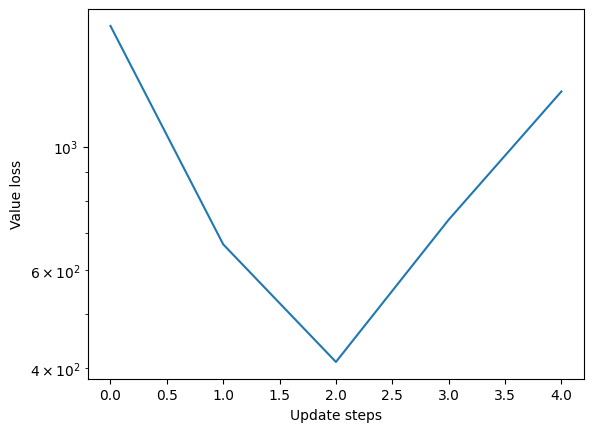

In [8]:
import matplotlib.pyplot as plt
value_loss = out["loss_info"]["loss/value_loss"].mean(-1).reshape(-1)
plt.plot(value_loss)
# log scale
plt.yscale('log')
plt.xlabel("Update steps")
plt.ylabel("Value loss")
plt.show()

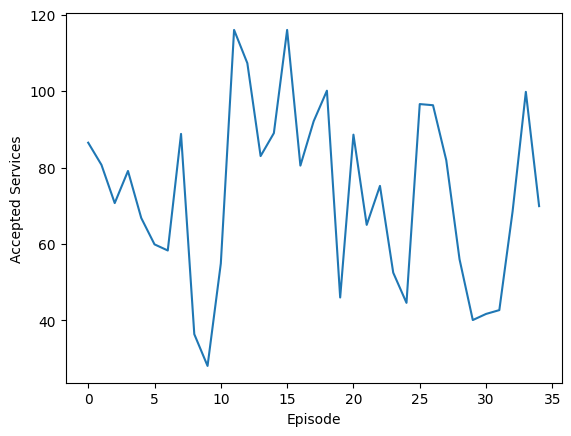

In [9]:
plt.plot(processed_data["accepted_services"]["episode_end_mean"])
# log scale
plt.xlabel("Episode")
plt.ylabel("Accepted Services")
plt.show()

In [ ]:
# TODO - see what other plots you can make with the processed_data

### Reload the model and train the policy

Redefine the training parameters to match the best ones found from the sweep

In [43]:
import sys
from xlron.environments.make_env import *
from xlron import parameter_flags

# We load the default flags
FLAGS = flags.FLAGS

# ... and training details
# TODO - change these to match the hyperparameters from your best sweep run
train_config = {
    "SEED": 0,
    "NUM_LEARNERS": 1,
    "TOTAL_TIMESTEPS": total_timesteps,
    "NUM_ENVS": 10,
    "ROLLOUT_LENGTH": 100,
    "UPDATE_EPOCHS": 5,
    "LR": 5e-4,
    "GAMMA": 1.0, # For pre-training the VF, we don't use a discount factor
    "GAE_LAMBDA": 1.0, # For pre-training the VF, we don't use GAE
    "LR_SCHEDULE": "warmup_cosine",
    "SCHEDULE_MULTIPLIER": 10,
    "warmup_schedule_multiplier": 2,
    "LAYER_NORM": True,
}

# We convert config to a Box container to make items accessible through both dict and dot notation
config = process_config(FLAGS, **env_config, **agent_config, **train_config)
config

Box({'logtostderr': False, 'alsologtostderr': False, 'log_dir': '', 'v': -1, 'verbosity': -1, 'logger_levels': {}, 'stderrthreshold': 'fatal', 'showprefixforinfo': True, 'chex_n_cpu_devices': 1, 'chex_assert_multiple_cpu_devices': False, 'run_with_pdb': False, 'pdb_post_mortem': False, 'pdb': False, 'run_with_profiling': False, 'profile_file': None, 'use_cprofile_for_profiling': True, 'only_check_args': False, 'test_srcdir': '', 'test_tmpdir': '/var/folders/5j/8r45ty_x4qj7wn99038f8m1c0000gn/T/absl_testing', 'test_random_seed': 301, 'test_randomize_ordering_seed': '', 'xml_output_file': '', 'chex_skip_pmap_variant_if_single_device': True, 'op_conversion_fallback_to_while_loop': True, 'delta_threshold': 0.5, 'tt_check_filter': False, 'tt_single_core_summaries': False, 'runtime_oom_exit': True, 'hbm_oom_exit': True, 'experimental_orbax_use_distributed_process_id': False, 'SEED': 0, 'NUM_LEARNERS': 1, 'NUM_DEVICES': 1, 'NUM_ENVS': 10, 'ROLLOUT_LENGTH': 100, 'NUM_UPDATES': 1, 'MINIBATCH_SIZ

### Reload the model and make sure the actor params are reset (but the VF is pre-trained)

In [51]:
# Reload the model from file
# Then we want to run the training again with the model loaded
config.RETRAIN_MODEL = True
config.model = None
config.MODEL_PATH = "/Users/michaeldoherty/git/XLRON/experimental/vf_pretraining/vf_pretrained"

# We need to reset the Actor parameters to random
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
model = orbax_checkpointer.restore(pathlib.Path(config.MODEL_PATH))
# Make sure the actor params have been reset (should have been reset before saving anyway)
model["model"]["params"]["ActorGNN_0"] = initial_actor_params
config.model = model


/Users/michaeldoherty/Library/Caches/pypoetry/virtualenvs/xlron-QeH3eSKC-py3.11/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


### Train the agent

In [53]:
from xlron.train.ppo import get_learner_fn

rng = jax.random.PRNGKey(config.SEED)
rng = jax.random.split(rng, config.NUM_LEARNERS)

NUM_UPDATES = (
        config.TOTAL_TIMESTEPS // config.ROLLOUT_LENGTH // config.NUM_ENVS
)
MINIBATCH_SIZE = (
        config.ROLLOUT_LENGTH * config.NUM_ENVS // config.NUM_MINIBATCHES
)
config.NUM_UPDATES = NUM_UPDATES
config.MINIBATCH_SIZE = MINIBATCH_SIZE

with TimeIt(tag='COMPILATION'):
    print(f"\n---BEGINNING COMPILATION---\n"
          f"Independent learners: {config.NUM_LEARNERS}\n"
          f"Environments per learner: {config.NUM_ENVS}\n"
          f"Timesteps per learner: {config.TOTAL_TIMESTEPS}\n"
          f"Timesteps per environment: {config.TOTAL_TIMESTEPS // config.NUM_ENVS}\n"
          f"Total timesteps: {config.TOTAL_TIMESTEPS * config.NUM_LEARNERS}\n"
          f"Total updates: {config.NUM_UPDATES * config.NUM_MINIBATCHES}\n"
          f"Batch size: {config.NUM_ENVS * config.ROLLOUT_LENGTH}\n"
          f"Minibatch size: {config.MINIBATCH_SIZE}\n")

    experiment_input, env, env_params = jax.vmap(experiment_data_setup, axis_name='learner', in_axes=(None, 0))(config, rng)
    # N.B. that we use the PPO here defined in train/ppo.py
    experiment_fn = get_learner_fn(env, env_params, experiment_input[0], config)
    run_experiment = jax.jit(jax.vmap(experiment_fn, axis_name='learner')).lower(experiment_input).compile()

# N.B. that increasing number of learner will increase the number of steps
# (essentially training for total_timesteps separately per learner)

start_time = time.time()
with TimeIt(tag='EXECUTION', frames=config.TOTAL_TIMESTEPS * config.NUM_LEARNERS):
    out_retrain = run_experiment(experiment_input)
    out_retrain["metrics"]["returns"].block_until_ready()  # Wait for all devices to finish
total_time = time.time() - start_time


---BEGINNING COMPILATION---
Independent learners: 1
Environments per learner: 10
Timesteps per learner: 5000
Timesteps per environment: 500
Total timesteps: 5000
Total updates: 5
Batch size: 1000
Minibatch size: 1000



<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Retraining model
COMPILATION: Elapsed time=33.84s
EXECUTION: Elapsed time=100.51s, FPS=4.97e+01


In [54]:
train_state = jax.tree.map(lambda x: x[0], out_retrain["runner_state"][0])
config.MODEL_PATH = "/Users/michaeldoherty/git/XLRON/experimental/vf_pretraining/retrained_model"
save_model(initial_train_state, "retrained_model", config)

Saving model to /Users/michaeldoherty/git/XLRON/experimental/vf_pretraining/retrained_model_1


In [55]:
merged_out_retrain, processed_data_retrain = process_metrics(config, out_retrain, total_time, merge_func)
processed_data_retrain["accepted_services"].keys()

Processing output metrics


dict_keys(['mean', 'std', 'iqr_upper', 'iqr_lower', 'episode_end_mean', 'episode_end_std', 'episode_end_iqr_upper', 'episode_end_iqr_lower'])

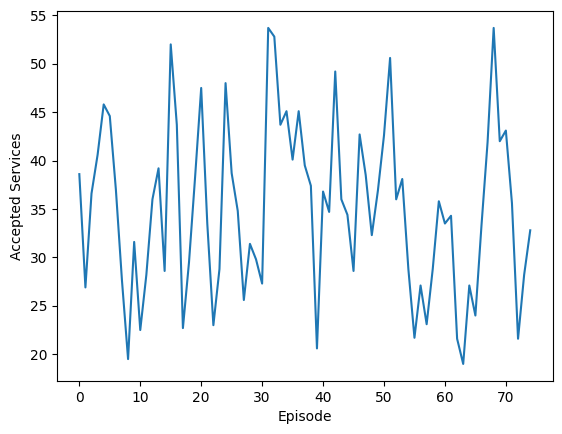

In [56]:
import matplotlib.pyplot as plt
plt.plot(processed_data_retrain["accepted_services"]["episode_end_mean"])
# log scale
plt.xlabel("Episode")
plt.ylabel("Accepted Services")
plt.show()

In [ ]:
# TODO - see what other plots you can make with the processed_data and loss metrics